As it turns out, this doesn't seem like a particularly great algorithm, but I'll try and go through what it's doing. I haven't worried about inefficeint coding / having milions of loops etc. yet.

The idea is to compress a lot of correlated random timeseries - so at each point in time there are many numbers to save. The hope is that the algorithm will exploit two facts about the data to enable compression: 

* Small changes from one time to the next are more likely than large ones
* Several of the timeseries are correlated

I'll try and explain what's happening by using a two correlated timeseries as an example at each step.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import math
from scipy.stats import chi2
import sys

Populating the interactive namespace from numpy and matplotlib


If we only encode the difference between each time, we can just treat the timeseries as a load of random numbers (here with a Gaussian distribution). The next cell makes a matrix of random numbers and then mixes them to make them correlated. It'd be nice to try this with real timeseries data.

In [19]:
def create_timeseries(number, length, sigma):
    delta_matrix = np.random.normal(0, sigma, [number,length])
    return delta_matrix

def mix_timeseries(series1, series2):
    N1 = np.shape(series1)[0]
    N2 = np.shape(series2)[0]
    weights = 2*np.random.rand(N1,N2) - np.ones([N1,N2]) #amount of each of series2 to add to series 1
    
    for j in range(N1):
        addvec = np.zeros(np.shape(series1)[1])
        for i in range(N2):
            addvec += weights[j,i]*series2[i,:]
        series1[j,:] += addvec
        
    return series1
        
def mix_with_single_timeseries(timeseries_mat, a, b):
    mix_with = create_timeseries(1, len(timeseries_mat[0,:]), 1)
    mix_array = mix_with
    for i in range(len(timeseries_mat[:,0])-1):
        mix_array = np.append(mix_array, mix_with, axis=0)
    return a*timeseries_mat + b*mix_array


    
timeseries_mat = mix_timeseries(create_timeseries(2, 1000, 1), create_timeseries(2, 1000, 1))
#timeseries_mat = mix_with_single_timeseries(timeseries_mat, 1, 1)

In this example timeseries_mat is 2 timeseries with 1000 elements in each

(2, 1000)


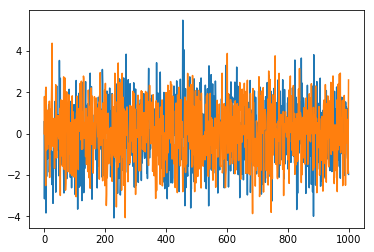

In [20]:
#just a demonstration cell
print(np.shape(timeseries_mat))

plot(range(0,1000),timeseries_mat[0,:])
plot(range(0,1000),timeseries_mat[1,:])

You can mostly ignore the code in the next cell, it's just something I copied so I couls show you the graph. The important thing for this it that this sort of distribution is a multivariate normal distribution and is characterised be the covariance matrix which gives the variance for each timeseries and the covaraince between each one. 

If you plot out the probability distribution for 2 timesereis you should get the kind of slanted oval shape that the graph below shows. The algorithm should give shorter keys for the points that fall on the brighter areas.

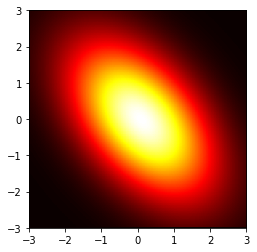

In [22]:
#just a demonstration cell
def bivariate_time_series(x_vec, y_vec, x_range_vec, y_range_vec):
    u_x = np.mean(x_vec)
    u_y = np.mean(y_vec)
    cov_mat = cov(x_vec, y_vec)
    coef = (1/(2*pi))*(np.linalg.det(cov_mat))**(-0.5)
    cov_inv = linalg.inv(cov_mat)
    
    prob_mat = np.zeros([size(x_range_vec),size(y_range_vec)])
    
    for i in range(1,size(x_range_vec-1)):
        for j in range(1,size(y_range_vec-1)):
            dist_from_mean = np.array([x_range_vec[i]-u_x, y_range_vec[j]-u_y ])
            a = np.dot(dist_from_mean, cov_inv)
            exponent = -0.5*np.dot(a, dist_from_mean)
            prob_mat[i,j] = coef*exp(exponent)
            
            if exponent > 0:
                print('fffff')
            if prob_mat[i,j] < 0:
                print('ff')
            
    return prob_mat

ax_len = 3
out = bivariate_time_series(timeseries_mat[0,:], timeseries_mat[1,:], arange(-ax_len,ax_len,0.02), arange(-ax_len,ax_len,0.02) )
extent = [-ax_len, ax_len, -ax_len, ax_len,]
plt.imshow(out, cmap='hot', interpolation='nearest', origin='lower', extent=extent)

It probably makes sense to try to explain the whole algorthim from this point and then explain what the functions do.

The first thing it does is to find the covariance matrix of the data and diagonalise it. (I didn't know this when I was developing the algorithm, but apparently diagonalising the covariance matrix is just an inefficient way to do a principal component analysis). If we apply these diagonalisation operators to the data, and then plot the new probaility distribution, it should look nice and aligned with the axes.

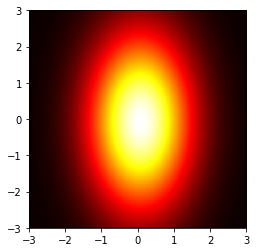

In [25]:
#just a demonstration cell
cov_mat = np.cov(timeseries_mat)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
rotated_timeseries_mat = np.zeros(np.shape(timeseries_mat))
for i in range(len(timeseries_mat[0,:])):
    rotated_timeseries_mat[:,i] = np.dot(eig_vecs.T, timeseries_mat[:,i])
    
out = bivariate_time_series(rotated_timeseries_mat[0,:], rotated_timeseries_mat[1,:], arange(-ax_len,ax_len,0.02), arange(-ax_len,ax_len,0.02) )
extent = [-ax_len, ax_len, -ax_len, ax_len,]
plt.imshow(out, cmap='hot', interpolation='nearest', origin='lower', extent=extent)

This doesn't change anything fundamental, it just makes the data easier to work with.


I think the trickiest thing to explain in text is how to map the data at a given time to a binary string. E.g. in 2D, you might have a grid of points described by a 16 bit string where the first 8 bits are the position in x and the remaining 8 bits are the position in y.

The problem with doing this is that you have to make sure every data point falls inside that grid, and for random numbers, either you have a huge grid (and so shitty compression) or eventually you just get a number you can't encode.

The main idea for this algorithm is to use different length bit strings and a spacer key to separate them. So for example, when encoding a data point close to the centre of the distribution you can use a really small grid determined by say, just 4 bits, 2 in x, 2 in y. 

The secondary method of compression that takes adavantage of the correlation is that you don't need to use the same number of bits for each dimension. The prob. dist. in the diagonalised data is elongated along one axis (see prev. cell). The more correlated the data, the more elongated it is. This means that you can use fewer bits to describe the data along the compressed axis. i.e. You can have rectangular grids instead of sqaure ones. (Obviously, it'd be nice to use ovals instead of rectangles, but it turns out that elliptical grids an unsolved problem for anythinghigher than 4 dimensions)

In [26]:
def find_min_bits_needed(rotated_timeseries_mat, resolution, eig_vals):
    #Set starting point
    tolerence = resolution
    bits_needed_matrix = np.zeros(np.shape(rotated_timeseries_mat))
    for i in range(len(rotated_timeseries_mat[0,:])):
        c_sq = resolution/1000
        step = 1
        while True:
        
            while True:
                bits_needed = bits_from_c_sq(c_sq, eig_vals, resolution) #Get bits needed per axis for given c_sq
                max_dist_in_each_axis = resolution*(2**bits_needed - 1)/2
                absolute_error_in_each_axis = np.abs(rotated_timeseries_mat[:,i]) - np.abs(max_dist_in_each_axis)

                if all(absolute_error_in_each_axis <= resolution/2):
                    break
                c_sq += step

            c_sq -= 2*step
            step = step/2
            if 2*step < tolerence:
                break
        
        bits_needed_matrix[:,i] = bits_needed
        
    return bits_needed_matrix

def my_count(string, substring):
    string_size = len(string)
    substring_size = len(substring)
    count = 0
    for i in range(string_size-substring_size+1):
        if string[i:i+substring_size] == substring:
            count+=1
    return count


def bits_from_c_sq(c_sq, eig_vals, resolution):
    max_for_each_axis = np.sqrt(eig_vals*c_sq)
    bits_needed = np.ceil((np.log(np.ceil(2*max_for_each_axis/resolution)))/np.log(2))
    return bits_needed

In [27]:
def timeseries_mat_to_binary(timeseries_mat, resolution):
    cov_mat = np.cov(timeseries_mat)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    rotated_timeseries_mat = np.zeros(np.shape(timeseries_mat))
    for i in range(len(timeseries_mat[0,:])):
        rotated_timeseries_mat[:,i] = np.dot(eig_vecs.T, timeseries_mat[:,i])
        
    '''Encoding to binary'''

    bits = find_min_bits_needed(rotated_timeseries_mat, resolution, eig_vals)
    points = 2**bits

    #No need for a point is there is only 1
    low_values_indices = points <= 1  
    points[low_values_indices] = 0

    shift = resolution*(points-1)/2
    #shift should be 0 for 0 pts
    low_values_indices_shift = shift <= 0 
    shift[low_values_indices_shift] = 0

    binary_mat = np.empty(np.shape(rotated_timeseries_mat), dtype=object)


    encoded_points = np.round((rotated_timeseries_mat+shift)/resolution)

    for i in range(len(rotated_timeseries_mat[0,:])):
        for j in range(len(rotated_timeseries_mat[:,0])):
            string = '{0:0' + str(int(bits[j,i]))+ 'b}'
            binary = string.format(int(encoded_points[j,i]))
            if bits[j,i] == 0:
                binary = ''
            binary_mat[j,i] = binary
            
    combined_binary_vec = np.empty(len(rotated_timeseries_mat[0,:]), dtype=object)
    for i in range(len(rotated_timeseries_mat[0,:])):
        combined_binary_vec[i] = np.sum(binary_mat[:,i])

    full_string = np.sum(combined_binary_vec)

    i = 0
    while True:
        while True:
            sep = '{0:0b}'.format(i)
            if full_string.find(sep) == -1:
                break
            i+=1

        #Assemble the string with the separator
        full_string_sep = ''
        for string in combined_binary_vec:
            full_string_sep = full_string_sep + string + sep
        full_string_sep = full_string_sep[:-len(sep)]  

        #Check that separator does not now occur more times than the number of elements
        i+=1
        if my_count(full_string_sep, sep) < len(rotated_timeseries_mat[0,:]):
            break
    
    return full_string_sep, cov_mat

In [28]:
def binary_to_timeseries_mat(full_string_sep, cov_mat, resolution):
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    combined_binary_vec_reconstructed = full_string_sep.split(sep)

    #Get binary_mat back from combined_binary_vec_reconstructed
    raw_vol = np.prod(np.sqrt(eig_vals))

    relative_lengths_of_ellipsoid = np.sqrt(eig_vals)*(1/raw_vol)**(1/len(eig_vals))

    bits_reconstructed = np.empty(np.shape(rotated_timeseries_mat), dtype=object)
    
    for i in range(len(combined_binary_vec_reconstructed)):
        sum_bits_ = len(combined_binary_vec_reconstructed[i])

        c_sq = resolution/1000
        tolerence = resolution
        step = 1
        while True:
            bits_needed = bits_from_c_sq(c_sq, eig_vals, resolution)
            c_sq += step
            if np.sum(bits_needed) >= sum_bits_ and np.sum(bits_needed) == sum_bits_ and sum_bits_ != np.sum(bits_from_c_sq(c_sq-tolerence, eig_vals, resolution)):
                break
            if np.sum(bits_needed) >= sum_bits_:
                c_sq -= step*1.5
                step = step/2
        bits_reconstructed[:,i] = bits_needed
        
        reconstructed_binary_mat = np.empty(np.shape(bits_reconstructed), dtype=object)

    for i in range(len(bits_reconstructed[0,:])):
        string_to_decode = combined_binary_vec_reconstructed[i]
        bit_count = 0
        for j in range(len(bits_reconstructed[:,0])):
            reconstructed_binary_mat[j,i] = string_to_decode[int(bit_count):int(bit_count+bits_reconstructed[j,i])]
            bit_count += bits_reconstructed[j,i]
            
    # reconstruct rotated_timeseries_mat

    reconstructed_points = 2**bits_reconstructed

    shift_reconstructed = resolution*(reconstructed_points-1)/2
    #shift should be 0 for 0 pts
    low_values_indices_shift = shift_reconstructed <= 0 
    shift_reconstructed[low_values_indices_shift] = 0

    reconstructed_rotated_timeseries_mat = np.zeros(np.shape(reconstructed_binary_mat))

    for i in range(len(reconstructed_binary_mat[0,:])):
        for j in range(len(reconstructed_binary_mat[:,0])):
            reconstructed_rotated_timeseries_mat[j,i] = resolution*int(reconstructed_binary_mat[j,i],2)-shift_reconstructed[j,i]

    #Undo rotation
    reconstructed_timeseries_mat = np.zeros(np.shape(reconstructed_rotated_timeseries_mat))
    inverse_matrix = inv(eig_vecs.T)

    for i in range(len(reconstructed_rotated_timeseries_mat[0,:])):
        reconstructed_timeseries_mat[:,i] = np.dot(inverse_matrix, reconstructed_rotated_timeseries_mat[:,i])
        
    return reconstructed_timeseries_mat

In [29]:
compression_factor = []

for resolution in arange(0.01,1,0.1):
    full_string_sep, cov_mat = timeseries_mat_to_binary(timeseries_mat, resolution)
    compression_factor.append(8*sys.getsizeof(timeseries_mat)/len(full_string_sep))
    print(resolution)
    

/Users/work/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in sqrt
/Users/work/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less_equal


0.01
0.11
0.21
0.31
0.41
0.51
0.61
0.71
0.81
0.91


In [30]:
compression_factor

[4.527750456653084,
 6.5709624796084825,
 6.819533358023385,
 7.245011522680007,
 7.983648188293589,
 8.131726704939751,
 8.622382768078133,
 9.500700228495614,
 9.034555267400295,
 9.374254545454546]